In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://zenn.dev/pharmax/articles/8796b892eed183',
  'content': 'Node. Nodeは、Graph上で実際のステップを実行するコンポーネントです。 例えば実際にLangChainを使用してLLMのモデルを呼び出す処理は、Node上で行いま'},
 {'url': 'https://weel.co.jp/media/tech/langgraph/',
  'content': '参考：https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/visualization.ipynb\nLangGraphを使うことにより複数のエージェントを定義することができ、それぞれに特定の役割を持たせることができます。また、各ステップを「ノード」として定義して「状態の遷移」を制御可能。さらに、条件付き遷移や処理の再実行が簡単にできるなどのメリットがあります。\nLangGraphはRAGのような使い方もできますが、LangGraphとRAGは異なっており、RAGはLLMに不足している知識を外部データベースから補完するのに対して、LangGraphはその処理の流れ(検索→生成→出力など)をノードとして組み、順序や条件を制御する役割を担っています。\nLangGraphの構成要素\nLangGraphにはノードや状態の遷移以外にも構成要素があります。※1\n先ほどの画像と見比べながら解説をします。 [...] ホーム\n生成AIテック\nやってみた系\nLangGraphとは？エージェントの使い方とワークフロー構築法をハンズオンで解説\n\nLangGraphとは？エージェントの使い方とワークフロー構築法をハンズオンで解説\n2025 4/10\nやってみた系\n2025-04-10\n\n押さえておきたいポイント\n\nLangChainのコンポーネントを使って処理フローをグラフ構造で制御できる\nノード間で状態（データ）を引き継ぎながら処理を進められる\nローカル環境で実装可能\n\nLangChainに似たLangGraphをご存知ですか？LangGraphはReplitやUber、LinkedInなどで使用されており

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

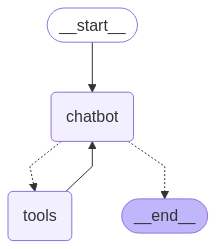

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！何かお手伝いできることがありますか？
1足す2は？
1足す2は3です。何か他に知りたいことがありますか？
1メートル以上の魚は？

[{"url": "https://www.zukan-bouz.com/syu/%E3%82%AA%E3%82%AA%E3%83%8B%E3%83%99", "content": "1m以上になる大型魚でイヤミのない魚なので知名度はないものの、徐々に人気を得ている。 関東の市場でも普通になっていて、切り身などで小売店に並ぶこともある"}, {"url": "https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q14260099909", "content": "友人と琵琶湖でバス釣りをしていたら、余裕で1m以上の巨大な魚を見ました。かなり近くで見たのですが、ビワコオオナマズでも、コイでもありません。"}]
1メートル以上の魚にはいくつかの種類があります。例えば、以下のような魚が挙げられます：

1. **オオニベ** - 1メートル以上になる大型魚で、徐々に人気が高まっている魚です。関東の市場でも見かけることがあります。詳細は[こちら](https://www.zukan-bouz.com/syu/%E3%82%AA%E3%82%AA%E3%83%8B%E3%83%99)で確認できます。

2. **ビワコオオナマズ** - 琵琶湖で見られる巨大な魚で、友人が実際に見た経験があります。詳細は[こちら](https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q14260099909)で確認できます。

他にも多くの種類の魚が1メートル以上に成長しますが、具体的にどの魚に興味がありますか？
ありがとうございました!
